In [1]:
# Import packages
import pandas as pd
import numpy as np

# Utilities

In [2]:
def one_hot_encoder(df, columns):
    one_hot = pd.get_dummies(df, columns=columns, prefix=columns)
    df = df.drop(columns, axis=1)
    return one_hot 

# Function to split test and train sets by 2/3 and 1/3 randomly
def split_test_train(df):
    train = df.sample(frac=2/3)
    test = df.loc[~df.index.isin(train.index), :]
    return train, test

def get_num_similarities(array1, array2):
    a = np.array(array1)
    b = np.array(array2)
    return np.sum(a == b)

# Winnow-2

In [3]:
# Promote weights
def promote(X, w, alpha):
    for index, x in enumerate(X):
        if x == 1:
            w[index] *= alpha
            
    return w

# Demote weights
def demote(X, w, alpha):
    for index, x in enumerate(X):
        if x == 1:
            w[index] /= alpha
            
    return w

# Make the prediciton, 1 if true, 0 if false
def make_prediction(X, w, theta):
    sum = 0
    for index, x in enumerate(X):
        sum += w[index] * int(x)
        
    if sum > theta:
        return 1
    
    return 0

# Implements winnow-2 algorithm
# parameters are X = set of boolean attributes
# C is the correct class value
def winnow_2(X, w, cls, theta, alpha):
    # Make the prediction on X
    prediction = make_prediction(X, w, theta)
    
    # Test prediction against class
    if prediction == cls:
        return w, prediction
    
    if prediction == 0 and cls==1:
        w = promote(X, w, alpha)
    else:
        w = demote(X, w, alpha)
        
    return w, prediction


In [4]:
# Run the algorithm on breast
def train_winnow2(X_train, classes, alpha, theta):
    
    # Initialize w to all 1s
    w = [1]*(X_train.shape[1])
    print('w = ' + str(w))
    print("Number of attributes = " + str(len(w)))
    
    # TRAIN
    predictions = []
    for index, row in X_train.iterrows():
        (w, p) = winnow_2(row, w, classes[index], theta, alpha)
        predictions.append(p)
        
    # Compare predictions to actual
    print("Training Predictions (% Correct)")
    print(get_num_similarities(classes, predictions) / len(X_train) * 100)
    
    return w
    
def test_winnow2(X_test, classes, alpha, theta, w):
    predictions = []
    for index, row in X_test.iterrows():
        (w, p) = winnow_2(row, w, classes[index], theta, alpha)
        predictions.append(p)
        
    # Compare predictions to actual
    print("Testing Predictions (% Correct)")
    print(get_num_similarities(classes, predictions) / len(X_test) * 100)

# Naive Bayes

In [5]:
def get_naive_bayes_model(classes, features):
    # Create the model
    value_counts = classes.value_counts().to_dict()
    num_samples = len(classes)
    prob_0 = value_counts[0] / num_samples if 0 in value_counts else 0
    prob_1 = value_counts[1] / num_samples if 1 in value_counts else 1
    feature_probs_f0_given0 = []
    feature_probs_f1_given0 = []
    feature_probs_f0_given1 = []
    feature_probs_f1_given1 = []
    zero_class_indexes = [i for i,x in enumerate(classes) if x == 0]
    one_class_indexes = [i for i,x in enumerate(classes) if x == 1]
    num_zero_classes = len(zero_class_indexes)
    num_one_classes = len(one_class_indexes)
    for index, colName in enumerate(features.columns):
        f_value_counts_given_0 = features.iloc[zero_class_indexes, index].value_counts().to_dict()
        f_value_counts_given_1 = features.iloc[one_class_indexes, index].value_counts().to_dict()
        prob_f0_given_c0 = f_value_counts_given_0[0] / num_zero_classes if 0 in f_value_counts_given_0 else 0
        prob_f1_given_c0 = f_value_counts_given_0[1] / num_zero_classes if 1 in f_value_counts_given_0 else 0
        prob_f0_given_c1 = f_value_counts_given_1[0] / num_one_classes if 0 in f_value_counts_given_1 else 0
        prob_f1_given_c1 = f_value_counts_given_1[1] / num_one_classes if 1 in f_value_counts_given_1 else 0
        feature_probs_f0_given0.append(prob_f0_given_c0)
        feature_probs_f1_given0.append(prob_f1_given_c0)
        feature_probs_f0_given1.append(prob_f0_given_c1)
        feature_probs_f1_given1.append(prob_f1_given_c1)
        
    print("THE MODEL")
    print("Probability of C = 0:", prob_0)
    print("Probability of C = 1:", prob_1)
    print("Probabilities of f = 0, given c = 0:", feature_probs_f0_given0)
    print("Probabilities of f = 1, given c = 0:", feature_probs_f1_given0)
    print("Probabilities of f = 0, given c = 1:", feature_probs_f0_given1)
    print("Probabilities of f = 1, given c = 1:", feature_probs_f1_given1)
    return (prob_0, prob_1, feature_probs_f0_given0, 
            feature_probs_f1_given0, feature_probs_f0_given1, 
            feature_probs_f1_given1)
   
    
def naive_bayes_make_predictions(data, prob_0, prob_1, feature_probs_f0_given0, 
                                 feature_probs_f1_given0, feature_probs_f0_given1, 
                                 feature_probs_f1_given1):
    # Calculate predictions by calculating the probability of each 
    # C=1 and C=0 in each sample(row)
    predictions = []
    for index, row in data.iterrows():
        c0_product = prob_0
        c1_product = prob_1
        for feature_index, feature in enumerate(row):
            if feature == 0:
                c0_product *= feature_probs_f0_given0[feature_index]
                c1_product *= feature_probs_f0_given1[feature_index]
            else:
                c0_product *= feature_probs_f1_given0[feature_index]
                c1_product *= feature_probs_f1_given1[feature_index]
        
        if c0_product > c1_product:
            predictions.append(0)
        else:
            predictions.append(1)
            
    return predictions


def naive_bayes(train_classes, test_classes, X_train, X_test):
    (prob_0, prob_1, 
    feature_probs_f0_given0, 
    feature_probs_f1_given0, 
    feature_probs_f0_given1, 
    feature_probs_f1_given1) = get_naive_bayes_model(train_classes, X_train) 
    
    # TRAIN
    predictions_train = naive_bayes_make_predictions(X_train, prob_0, prob_1, 
                                                     feature_probs_f0_given0, 
                                                     feature_probs_f1_given0, 
                                                     feature_probs_f0_given1, 
                                                     feature_probs_f1_given1)
    
    # Compare training predictions to actual
    print("\n")
    print("TRAINING PREDICTIONS")
    print(predictions_train)
    print("Training Predictions (% Correct)")
    print(get_num_similarities(train_classes, predictions_train) / len(X_train) * 100)
    
    # TEST
    predictions = naive_bayes_make_predictions(X_test, prob_0, prob_1, 
                                               feature_probs_f0_given0, 
                                               feature_probs_f1_given0, 
                                               feature_probs_f0_given1, 
                                               feature_probs_f1_given1)
    
    # Compare training predictions to actual
    print("\n")
    print("TEST PREDICTIONS")
    print(predictions)
    print("Testing Predictions (% Correct)")
    print(get_num_similarities(test_classes, predictions) / len(X_test) * 100)


# Breast Cancer

In [6]:
# Read in breast cancer data
df_breast = pd.read_csv('./data/breast-cancer-wisconsin.data', header=None)
df_breast.shape

# This data has nine attributes including the class attribute (which is Benign = 2, Malignant = 4)
df_breast.columns = ["Sample Id", "Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses", "Class: Benign or Malignant"]

# Find missing values and remove them, since there are so few
# The documentation notes that there are16 missing values in group 1 and 6 denoted by '?'
# I found 16 values in Group 6
# Since there are so few missing values I dropped those rows
df_breast.isin(['?']).sum()
df_breast_all = df_breast[df_breast["Bare Nuclei"] != '?']
df_breast_all.isin(['?']).sum()

# Drop Sample Id
df_breast_all = df_breast_all.drop('Sample Id', axis=1)

# Generate boolean classifiers (0 = Benign, 1 = Malignant)
df_breast_all.loc[df_breast_all["Class: Benign or Malignant"] == 2, "Class: Benign or Malignant"] = 0
df_breast_all.loc[df_breast_all["Class: Benign or Malignant"] == 4, "Class: Benign or Malignant"] = 1

# Do some analysis on the breast set
df_breast_analysis = df_breast_all.copy()
df_breast_analysis["sum"] = df_breast_analysis[df_breast_all.columns.values.tolist()].sum(axis=1)
df_breast_analysis.head()

# Plot Sums againts class in a box plot, this will allow us to choose an appropriate theta
boxplot = df_breast_analysis[["Class: Benign or Malignant", "sum"]].boxplot(by='Class: Benign or Malignant')

In [7]:
# Split breast dataset
X_breast_train, X_breast_test = split_test_train(df_breast_all)
print("Sample size = ", len(df_breast_all))
print("Training set size = ", len(X_breast_train))
print("Test set size = ", len(X_breast_test))

Sample size =  683
Training set size =  455
Test set size =  228


In [8]:
# Run Winnow-2 on breast
theta = 38 # Chosen based on box plot of sums
alpha = 1.6 # Started with 2 and tuned until I got the best result
print("theta = " + str(theta))
print("alpha = " + str(alpha))
w = train_winnow2(X_breast_train.iloc[:,0:9], X_breast_train.iloc[:,9], alpha, theta)
test_winnow2(X_breast_test.iloc[:,0:9], X_breast_test.iloc[:,9], alpha, theta, w)

theta = 38
alpha = 1.6
w = [1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of attributes = 9
Training Predictions (% Correct)
94.72527472527472
Testing Predictions (% Correct)
89.47368421052632


In [9]:
# One hot encode
columns_to_encode = df_breast_all.columns.values.tolist()
del columns_to_encode[9]
df_breast_encoded = one_hot_encoder(df_breast_all, columns_to_encode)

# Split breast dataset
X_breast_train_encoded, X_breast_test_encoded = split_test_train(df_breast_encoded)

In [10]:
# Run naive bayes on breast
naive_bayes(X_breast_train_encoded["Class: Benign or Malignant"],
                  X_breast_test_encoded["Class: Benign or Malignant"],
                  X_breast_train_encoded.iloc[:,1:90], 
                  X_breast_test_encoded.iloc[:,1:90])
    

THE MODEL
Probability of C = 0: 0.6593406593406593
Probability of C = 1: 0.34065934065934067
Probabilities of f = 0, given c = 0: [0.6733333333333333, 0.9133333333333333, 0.7933333333333333, 0.8366666666666667, 0.8233333333333334, 0.9766666666666667, 0.9966666666666667, 0.9866666666666667, 1.0, 1.0, 0.16666666666666666, 0.92, 0.9366666666666666, 0.98, 1.0, 1.0, 0.9966666666666667, 1.0, 1.0, 1.0, 0.21666666666666667, 0.8833333333333333, 0.94, 0.97, 1.0, 0.9933333333333333, 0.9966666666666667, 1.0, 1.0, 1.0, 0.19, 0.9233333333333333, 0.9233333333333333, 0.9833333333333333, 0.9933333333333333, 0.99, 1.0, 1.0, 1.0, 0.9966666666666667, 0.91, 0.20333333333333334, 0.93, 0.98, 0.99, 0.9966666666666667, 0.9966666666666667, 0.9966666666666667, 1.0, 0.9966666666666667, 0.13333333333333333, 0.9933333333333333, 0.9533333333333334, 0.9633333333333334, 0.9933333333333333, 0.97, 1.0, 0.9966666666666667, 0.9966666666666667, 1.0, 0.67, 0.63, 0.74, 0.9833333333333333, 0.99, 1.0, 0.9866666666666667, 1.0, 

# Iris

In [11]:
# Read in Iris dataset and set column names
df_iris = pd.read_csv('./data/iris.data', header=None)
df_iris.columns = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)", "Class"]
df_iris[df_iris["Class"] == "Iris-virginica"].head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class
100,6.3,3.3,6.0,2.5,Iris-virginica
101,5.8,2.7,5.1,1.9,Iris-virginica
102,7.1,3.0,5.9,2.1,Iris-virginica
103,6.3,2.9,5.6,1.8,Iris-virginica
104,6.5,3.0,5.8,2.2,Iris-virginica


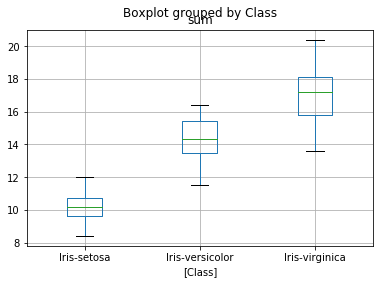

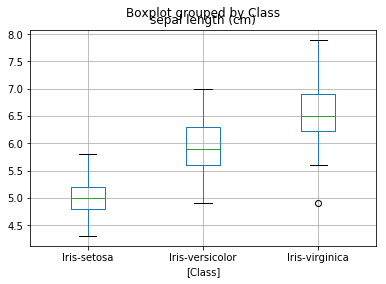

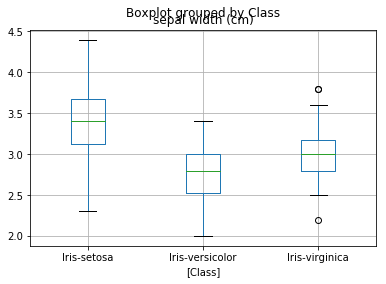

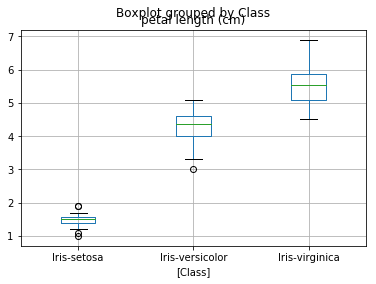

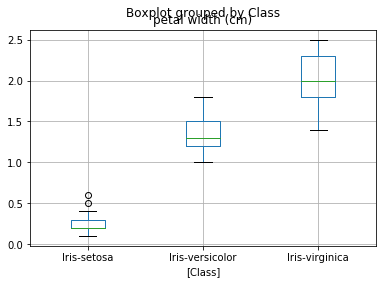

In [12]:

# Do some analysis on the iris set
df_iris_analysis = df_iris.copy()
df_iris_analysis["sum"] = df_iris_analysis[df_iris_analysis.columns.values.tolist()[0:5]].sum(axis=1)
df_iris_analysis.head()

boxplot = df_iris_analysis[["Class", "sum"]].boxplot(by="Class")
boxplot = df_iris[["Class", "sepal length (cm)"]].boxplot(by="Class")
boxplot = df_iris[["Class", "sepal width (cm)"]].boxplot(by="Class")
boxplot = df_iris[["Class", "petal length (cm)"]].boxplot(by="Class")
boxplot = df_iris[["Class", "petal width (cm)"]].boxplot(by="Class")

In [13]:
# Generate boolean classifiers (0 = not-Iris-virginica, 1 = Iris-virginica)
df_iris.loc[df_iris["Class"] == "Iris-virginica", "Class_Bool"] = 1
df_iris.loc[df_iris["Class"] != "Iris-virginica", "Class_Bool"] = 0

In [14]:
# Split iris dataset
X_iris_train, X_iris_test = split_test_train(df_iris)
print("Sample size = ", len(df_iris))
print("Training set size = ", len(X_iris_train))
print("Test set size = ", len(X_iris_test))
X_iris_train.head()

Sample size =  150
Training set size =  100
Test set size =  50


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,Class_Bool
137,6.4,3.1,5.5,1.8,Iris-virginica,1.0
83,6.0,2.7,5.1,1.6,Iris-versicolor,0.0
27,5.2,3.5,1.5,0.2,Iris-setosa,0.0
44,5.1,3.8,1.9,0.4,Iris-setosa,0.0
13,4.3,3.0,1.1,0.1,Iris-setosa,0.0


In [15]:

# Run Winnow-2 on Iris, I made this a two class problem by running
# it for Iris-virginica (1) or not-Iris-virginica (0)
# Given more time, I would write the algorithm to handle all three classes
theta = 16 # Chosen based on box plot of sums
alpha = 2 # Started with 2 and tuned until I got the best result
print("theta = " + str(theta))
print("alpha = " + str(alpha))
w = train_winnow2(X_iris_train.iloc[:,0:4], X_iris_train.iloc[:,5], alpha, theta)
test_winnow2(X_iris_test.iloc[:,0:4], X_iris_test.iloc[:,5], alpha, theta, w)

theta = 16
alpha = 2
w = [1, 1, 1, 1]
Number of attributes = 4
Training Predictions (% Correct)
72.0
Testing Predictions (% Correct)
76.0


In [16]:
# I encoded these by hand based on the box plots that I created
sepal_length_cond_1 = df_iris["sepal length (cm)"] > 6
sepal_length_cond_0 = df_iris["sepal length (cm)"] <= 6
sepal_width_cond_1 = (df_iris["sepal width (cm)"]  > 2.7) & (df_iris["sepal width (cm)"] < 3.25)
sepal_width_cond_0 = (df_iris["sepal width (cm)"]  <= 2.7) | (df_iris["sepal width (cm)"] >= 3.25)
petal_length_cond_1 = df_iris["petal length (cm)"] > 5
petal_length_cond_0 = df_iris["petal length (cm)"] <= 5
petal_width_cond_1 = df_iris["petal width (cm)"] > 1.5
petal_width_cond_0 = df_iris["petal width (cm)"] <= 1.5

df_iris_encoded = df_iris.copy()
df_iris_encoded.loc[sepal_length_cond_1, "sepal_length_cond_bool"] = 1
df_iris_encoded.loc[sepal_length_cond_0, "sepal_length_cond_bool"] = 0
df_iris_encoded.loc[sepal_width_cond_1, "sepal_width_cond_bool"] = 1
df_iris_encoded.loc[sepal_width_cond_0, "sepal_width_cond_bool"] = 0
df_iris_encoded.loc[petal_length_cond_1, "petal_length_cond_bool"] = 1
df_iris_encoded.loc[petal_length_cond_0, "petal_length_cond_bool"] = 0
df_iris_encoded.loc[petal_width_cond_1, "petal_width_cond_bool"] = 1
df_iris_encoded.loc[petal_width_cond_0, "petal_width_cond_bool"] = 0
df_iris_encoded.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,Class_Bool,sepal_length_cond_bool,sepal_width_cond_bool,petal_length_cond_bool,petal_width_cond_bool
0,5.1,3.5,1.4,0.2,Iris-setosa,0.0,0.0,0.0,0.0,0.0
1,4.9,3.0,1.4,0.2,Iris-setosa,0.0,0.0,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,Iris-setosa,0.0,0.0,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,Iris-setosa,0.0,0.0,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,Iris-setosa,0.0,0.0,0.0,0.0,0.0


In [17]:
# Split iris dataset
X_iris_train, X_iris_test = split_test_train(df_iris_encoded)
print("Sample size = ", len(df_iris))
print("Training set size = ", len(X_iris_train))
print("Test set size = ", len(X_iris_test))
X_iris_train.head()

Sample size =  150
Training set size =  100
Test set size =  50


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Class,Class_Bool,sepal_length_cond_bool,sepal_width_cond_bool,petal_length_cond_bool,petal_width_cond_bool
149,5.9,3.0,5.1,1.8,Iris-virginica,1.0,0.0,1.0,1.0,1.0
59,5.2,2.7,3.9,1.4,Iris-versicolor,0.0,0.0,0.0,0.0,0.0
58,6.6,2.9,4.6,1.3,Iris-versicolor,0.0,1.0,1.0,0.0,0.0
43,5.0,3.5,1.6,0.6,Iris-setosa,0.0,0.0,0.0,0.0,0.0
70,5.9,3.2,4.8,1.8,Iris-versicolor,0.0,0.0,1.0,0.0,1.0


In [18]:

# Run naive bayes on votes
naive_bayes(X_iris_train.iloc[:,5],X_iris_test.iloc[:,5], X_iris_train.iloc[:,6:], X_iris_test.iloc[:,6:])

THE MODEL
Probability of C = 0: 0.73
Probability of C = 1: 0.27
Probabilities of f = 0, given c = 0: [0.821917808219178, 0.5616438356164384, 1.0, 0.9726027397260274]
Probabilities of f = 1, given c = 0: [0.1780821917808219, 0.4383561643835616, 0, 0.0273972602739726]
Probabilities of f = 0, given c = 1: [0.14814814814814814, 0.3333333333333333, 0.14814814814814814, 0.07407407407407407]
Probabilities of f = 1, given c = 1: [0.8518518518518519, 0.6666666666666666, 0.8518518518518519, 0.9259259259259259]


TRAINING PREDICTIONS
[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]
Training Predictions (% Correct)
96.0


TEST PREDICTIONS
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1

# Votes

In [19]:
df_vote = pd.read_csv('./data/house-votes-84.data', header=None)
df_vote.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


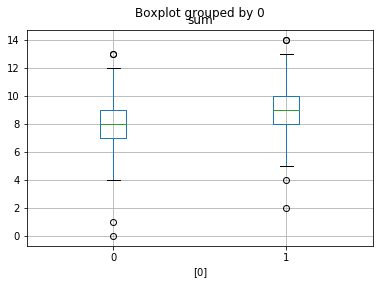

In [20]:
# Generate boolean classifiers (0 = republican, 1 = democrat)
df_vote.loc[df_vote[0] == "republican", 0] = 0
df_vote.loc[df_vote[0] == "democrat", 0] = 1

# Generate boolean classifiers (0 = n, 1 = y)
# Set ? to n, since there is no good way to impute votes
df_vote.replace('n', 0, inplace=True)
df_vote.replace('y', 1, inplace=True)
df_vote.replace('?', 0, inplace=True)
df_vote.head()

# Do some analysis
df_vote_analysis = df_vote.copy()
df_vote_analysis["sum"] = df_vote_analysis[df_vote.columns.values.tolist()].sum(axis=1)
df_vote_analysis.head()

# Plot Sums againts class in a box plot, this will allow us to choose an appropriate theta
boxplot = df_vote_analysis[[0, "sum"]].boxplot(by=0)

In [21]:
# Split vote dataset
X_vote_train, X_vote_test = split_test_train(df_vote)
print("Sample size = ", len(df_vote))
print("Training set size = ", len(X_vote_train))
print("Test set size = ", len(X_vote_test))
X_vote_train.head()

Sample size =  435
Training set size =  290
Test set size =  145


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
5,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,1
243,1,0,1,1,0,0,0,1,1,0,1,0,0,1,0,1,1
224,0,0,1,0,1,1,1,0,0,0,1,0,0,1,1,0,0
40,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0
269,1,1,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1


In [22]:
# Run Winnow-2 on breast
theta = 8.25 # Chosen based on box plot of sums
alpha = 2 # Started with 2 and tuned until I got the best result
print("theta = " + str(theta))
print("alpha = " + str(alpha))
w = train_winnow2(X_vote_train.iloc[:,1:], X_vote_train.iloc[:,0], alpha, theta)
test_winnow2(X_vote_test.iloc[:,1:], X_vote_test.iloc[:,0], alpha, theta, w)

theta = 8.25
alpha = 2
w = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of attributes = 16
Training Predictions (% Correct)
83.44827586206897
Testing Predictions (% Correct)
82.75862068965517


In [23]:
# Run naive bayes on votes
naive_bayes(X_vote_train[0],X_vote_test[0], X_vote_train.iloc[:,1:16], X_vote_test.iloc[:,1:16])

THE MODEL
Probability of C = 0: 0.3758620689655172
Probability of C = 1: 0.6241379310344828
Probabilities of f = 0, given c = 0: [0.8073394495412844, 0.5596330275229358, 0.8899082568807339, 0.027522935779816515, 0.05504587155963303, 0.10091743119266056, 0.7706422018348624, 0.8807339449541285, 0.8990825688073395, 0.44954128440366975, 0.8532110091743119, 0.1559633027522936, 0.1743119266055046, 0.06422018348623854, 0.926605504587156]
Probabilities of f = 1, given c = 0: [0.1926605504587156, 0.44036697247706424, 0.11009174311926606, 0.9724770642201835, 0.944954128440367, 0.8990825688073395, 0.22935779816513763, 0.11926605504587157, 0.10091743119266056, 0.5504587155963303, 0.14678899082568808, 0.8440366972477065, 0.8256880733944955, 0.9357798165137615, 0.07339449541284404]
Probabilities of f = 0, given c = 1: [0.4088397790055249, 0.574585635359116, 0.13259668508287292, 0.9502762430939227, 0.8066298342541437, 0.5303867403314917, 0.2154696132596685, 0.16022099447513813, 0.2983425414364641, 0.